# helper functions

In [15]:
import os
from dotenv import load_dotenv
import chromadb
from openai import OpenAI
from chromadb.utils import embedding_functions
import re
import pandas as pd

load_dotenv()
openai_key = os.getenv("OPENAI_API_KEY")

openai_ef = embedding_functions.OpenAIEmbeddingFunction(
    api_key=openai_key, model_name="text-embedding-3-small",
)

# chroma client
chroma_client = chromadb.PersistentClient(path="./data/chroma_persistent_storage")
collection_name = "document_qa_collection"
collection = chroma_client.get_or_create_collection(
    name=collection_name,embedding_function=openai_ef
)

client = OpenAI(api_key=openai_key)

def query_documents(question, n_results=10):
    openai_ef = embedding_functions.OpenAIEmbeddingFunction(
        api_key=openai_key, model_name="text-embedding-3-small"
    )

    collection = chroma_client.get_or_create_collection(
        name=collection_name, embedding_function=openai_ef
    )
    print(f"🔍 Querying collection: {collection.name}")

    results = collection.query(query_texts=question, n_results=n_results)
    relevant_chunks = [doc for sublist in results["documents"] for doc in sublist]

    citations = []
    for idx, _ in enumerate(results["documents"][0]):
        doc_id = results["ids"][0][idx]
        citations.append(doc_id)

    return relevant_chunks, citations

def construct_advanced_prompt(question, context, citations):
    # Format citations into the context
    formatted_citations = "\n".join(
        f"[Source {citation.replace('_', ' ')}]" for citation in citations
    )
    
    return f"""
    # Retrieval-Augmented Generation (RAG) Prompt

    ## Context Specification
    - Question Domain: Precise Information Retrieval
    - Retrieval Methodology: Semantic Search
    - Citation Requirement: Mandatory

    ## Question
    {question}

    ## Available Knowledge Sources
    {context}

    ## Source Citations
    {formatted_citations}

    ## Response Guidelines
    1. Answer ONLY using provided sources
    2. Cite sources explicitly for each claim
    3. Cite in format: [Source #]
    4. If information is insufficient, state limitations
    5. Maintain academic rigor in response
    6. Keep your answer small and precise
    7. Focus only on important pages

    ## Citation Instruction
    - Directly attribute information to sources
    - Use [Source #] immediately after relevant information
    - Highlight source relevance and confidence
    """
    
def format_chunks(relevant_chunks, citations):
    formatted_chunks = []
    for i in range(len(relevant_chunks)):
        try:
            citation = citations[i] if citations and i < len(citations) else f"Unknown Source {i+1}"
            chunk = relevant_chunks[i] if relevant_chunks and i < len(relevant_chunks) else "No content available"
            clean_citation = str(citation).split('.')[0].strip()
            formatted_chunk = f"[Source {clean_citation}]:\n{chunk}"
            formatted_chunks.append(formatted_chunk)
        
        except Exception as e:
            # Fallback for any unexpected errors
            formatted_chunks.append(f"[Source Error]: Unable to format source {i+1}")
    
    return formatted_chunks

def generate_response(question, formatted_chucks, citations, temperature=None):

    
    context = "\n\n".join(formatted_chucks)
    prompt = construct_advanced_prompt(question, context, citations)

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": prompt,
            },
            {
                "role": "user",
                "content": question,
            },
            
        ],
        temperature=temperature
    )

    answer = response.choices[0].message.content
    return answer

def chunks_used_by_ai(df,pages):
    ai_pages = ["page_"+str(page) for page in pages]
    filtered_df = df[df['Pages'].isin(ai_pages)]
    grouped_df = filtered_df.groupby('Pages')['Chunks'].apply(list).reset_index()
    return grouped_df
    
    
def retrieve_and_generate(question,temperature =None):
    chunks,citations = query_documents(question)

    extracted_citations = [citation.split('.')[0] for citation in citations]
    formatted_chunks = format_chunks(chunks, citations)
    ai_response = generate_response(question, formatted_chunks, extracted_citations,temperature).replace("_"," ")
    # print(ai_response)
    
    # print(chunks)
    matches = re.findall(r'age (\d+)\]', ai_response)

    # Convert matches to a sorted list of unique page numbers
    pages = sorted(set(map(int, matches)))
    # print(chunks)

    df = pd.DataFrame({
        'Chunks': chunks,
        'Pages': extracted_citations
    })

    ai_chunks = chunks_used_by_ai(df,pages)
    
    return ai_response, pages, ai_chunks

import pandas as pd
import sqlite3

def get_texts_by_ids(ids, db_path="../application.db"):
    if not ids:
        return []

    placeholders = ','.join(['?'] * len(ids))
    query = f"SELECT id, text FROM chunks WHERE id IN ({placeholders})"

    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute(query, ids)
    rows = cursor.fetchall()
    conn.close()

    # Sort results in the same order as input IDs
    id_to_text = {row[0]: row[1] for row in rows}
    texts = [id_to_text.get(i) for i in ids]

    return texts

from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score

def evaluate_generation_metrics_multi_ref(generated_answers, reference_answers_list):
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    smooth = SmoothingFunction().method4

    results = []

    for gen, refs in zip(generated_answers, reference_answers_list):
        # Compute scores for all refs and pick the best

        rouge_l_scores = [rouge.score(ref, gen)['rougeL'].fmeasure for ref in refs]
        
        bleu_scores = [sentence_bleu([ref.split()], gen.split(), smoothing_function=smooth) for ref in refs]

        # BERTScore across all references

        P, R, F1 = bert_score([gen]*len(refs), refs, lang="en", model_type="bert-base-uncased")

        best_bert_f1 = max(F1).item()

        results.append({
            "generated": gen,
            "references": refs,
            "rougeL": max(rouge_l_scores),
            "bleu": max(bleu_scores),
            "bertscore_f1": best_bert_f1
        })

    return results

import os
import sqlite3
import pandas as pd
def load_results_from_sqlite(db_path='../application.db'):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query("SELECT * FROM results", conn)
    conn.close()
    return df

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [16]:

results_df = load_results_from_sqlite()

In [17]:
doc1_df_low_complexity = results_df.iloc[5:10]
doc2_df_medium_complexity = results_df.iloc[10:15]
doc3_df_high_complexity = results_df.iloc[0:5]

# Doc 1

### Calc results

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection

--- Evaluation 1 ---
📊 ROUGE-L: 0.2708
📊 BLEU: 0.1016
📊 BERTScore F1: 0.6343

--- Evaluation 2 ---
📊 ROUGE-L: 0.2617
📊 BLEU: 0.1283
📊 BERTScore F1: 0.5849

--- Evaluation 3 ---
📊 ROUGE-L: 0.3607
📊 BLEU: 0.1453
📊 BERTScore F1: 0.6442

--- Evaluation 4 ---
📊 ROUGE-L: 0.3116
📊 BLEU: 0.0923
📊 BERTScore F1: 0.5989

--- Evaluation 5 ---
📊 ROUGE-L: 0.2055
📊 BLEU: 0.0253
📊 BERTScore F1: 0.5802


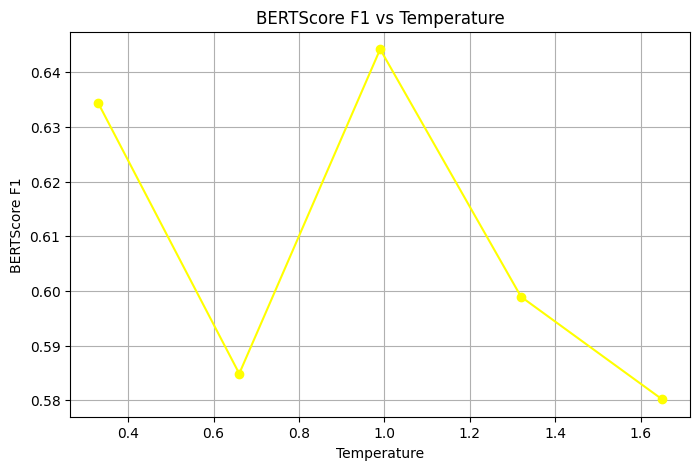

In [19]:
import ast
evaluation_data_1 = []
temperature = 0
for i, row in doc1_df_low_complexity.iterrows():
    temperature += 0.33
    ground_truth_list = ast.literal_eval(row['ground_truth_ids'])
    ground_truths = get_texts_by_ids(ground_truth_list)
    
    evaluation_data_1.append({
        "question": row["question"],
        "chunk_ids": ground_truth_list,
        "ground_truths": ground_truths,
        "temperature": temperature
    })

generated_answers_1 = []
reference_answers_list_1 = []

for item in evaluation_data_1:
    question = item["question"]
    references = item["ground_truths"]

    response, _, _ = retrieve_and_generate(question,item["temperature"])
    generated_answers_1.append(response)
    reference_answers_list_1.append(references)
    
metrics_1 = evaluate_generation_metrics_multi_ref(generated_answers_1, reference_answers_list_1)

for i, m in enumerate(metrics_1):
    print(f"\n--- Evaluation {i+1} ---")
    print(f"📊 ROUGE-L: {m['rougeL']:.4f}")
    print(f"📊 BLEU: {m['bleu']:.4f}")
    print(f"📊 BERTScore F1: {m['bertscore_f1']:.4f}")
    
doc1_results = []

for i, (eval_item, metric_item) in enumerate(zip(evaluation_data_1, metrics_1)):
    doc1_results.append({
        "id":"Query " + str(i+1) ,
        "ground_truths": len(eval_item["ground_truths"]),
        "temperature": eval_item["temperature"],
        "bertscore_f1": metric_item["bertscore_f1"]
    })
    
import matplotlib.pyplot as plt
temperatures = [d['temperature'] for d in doc1_results]
f1_scores = [d['bertscore_f1'] for d in doc1_results]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(temperatures, f1_scores, marker='o', linestyle='-', color='yellow')
plt.title('BERTScore F1 vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('BERTScore F1')
plt.grid(True)
plt.show()

# Doc 2

### Calc results

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection

--- Evaluation 1 ---
📊 ROUGE-L: 0.1449
📊 BLEU: 0.0262
📊 BERTScore F1: 0.5436

--- Evaluation 2 ---
📊 ROUGE-L: 0.1302
📊 BLEU: 0.0016
📊 BERTScore F1: 0.4917

--- Evaluation 3 ---
📊 ROUGE-L: 0.1422
📊 BLEU: 0.0192
📊 BERTScore F1: 0.4895

--- Evaluation 4 ---
📊 ROUGE-L: 0.1799
📊 BLEU: 0.0265
📊 BERTScore F1: 0.5852

--- Evaluation 5 ---
📊 ROUGE-L: 0.0177
📊 BLEU: 0.0011
📊 BERTScore F1: 0.4860


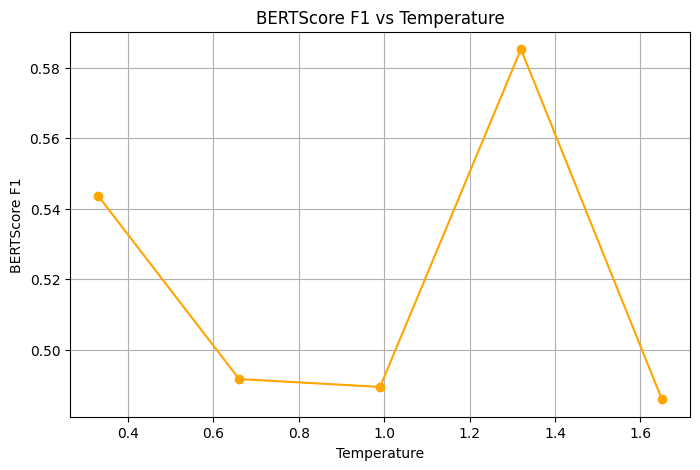

In [20]:
import ast
evaluation_data_2 = []
temperature = 0
for i, row in doc2_df_medium_complexity.iterrows():
    temperature += 0.33
    ground_truth_list = ast.literal_eval(row['ground_truth_ids'])
    ground_truths = get_texts_by_ids(ground_truth_list)
    
    evaluation_data_2.append({
        "question": row["question"],
        "chunk_ids": ground_truth_list,
        "ground_truths": ground_truths,
        "temperature": temperature
    })

generated_answers_2 = []
reference_answers_list_2 = []

for item in evaluation_data_2:
    question = item["question"]
    references = item["ground_truths"]

    response, _, _ = retrieve_and_generate(question,item["temperature"])
    generated_answers_2.append(response)
    reference_answers_list_2.append(references)
    
metrics_2 = evaluate_generation_metrics_multi_ref(generated_answers_2, reference_answers_list_2)

for i, m in enumerate(metrics_2):
    print(f"\n--- Evaluation {i+1} ---")
    print(f"📊 ROUGE-L: {m['rougeL']:.4f}")
    print(f"📊 BLEU: {m['bleu']:.4f}")
    print(f"📊 BERTScore F1: {m['bertscore_f1']:.4f}")
    
doc2_results = []

for i, (eval_item, metric_item) in enumerate(zip(evaluation_data_2, metrics_2)):
    doc2_results.append({
        "id":"Query " + str(i+1) ,
        "ground_truths": len(eval_item["ground_truths"]),
        "temperature": eval_item["temperature"],
        "bertscore_f1": metric_item["bertscore_f1"]
    })
    
import matplotlib.pyplot as plt
temperatures = [d['temperature'] for d in doc2_results]
f1_scores = [d['bertscore_f1'] for d in doc2_results]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(temperatures, f1_scores, marker='o', linestyle='-', color='orange')
plt.title('BERTScore F1 vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('BERTScore F1')
plt.grid(True)
plt.show()

# Doc 3

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


🔍 Querying collection: document_qa_collection

--- Evaluation 1 ---
📊 ROUGE-L: 0.1272
📊 BLEU: 0.0032
📊 BERTScore F1: 0.4817

--- Evaluation 2 ---
📊 ROUGE-L: 0.2040
📊 BLEU: 0.0227
📊 BERTScore F1: 0.5759

--- Evaluation 3 ---
📊 ROUGE-L: 0.0882
📊 BLEU: 0.0047
📊 BERTScore F1: 0.4182

--- Evaluation 4 ---
📊 ROUGE-L: 0.1824
📊 BLEU: 0.0480
📊 BERTScore F1: 0.5342

--- Evaluation 5 ---
📊 ROUGE-L: 0.1111
📊 BLEU: 0.0088
📊 BERTScore F1: 0.4738


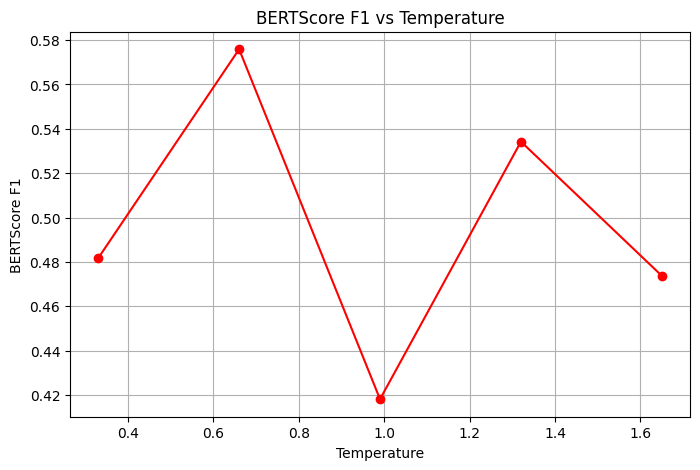

In [21]:
import ast
evaluation_data_3 = []
temperature = 0
for i, row in doc3_df_high_complexity.iterrows():
    temperature += 0.33
    ground_truth_list = ast.literal_eval(row['ground_truth_ids'])
    ground_truths = get_texts_by_ids(ground_truth_list)
    
    evaluation_data_3.append({
        "question": row["question"],
        "chunk_ids": ground_truth_list,
        "ground_truths": ground_truths,
        "temperature": temperature
    })

generated_answers_3 = []
reference_answers_list_3 = []

for item in evaluation_data_3:
    question = item["question"]
    references = item["ground_truths"]

    response, _, _ = retrieve_and_generate(question,item["temperature"])
    generated_answers_3.append(response)
    reference_answers_list_3.append(references)
    
metrics_3 = evaluate_generation_metrics_multi_ref(generated_answers_3, reference_answers_list_3)

for i, m in enumerate(metrics_3):
    print(f"\n--- Evaluation {i+1} ---")
    print(f"📊 ROUGE-L: {m['rougeL']:.4f}")
    print(f"📊 BLEU: {m['bleu']:.4f}")
    print(f"📊 BERTScore F1: {m['bertscore_f1']:.4f}")
    
doc3_results = []

for i, (eval_item, metric_item) in enumerate(zip(evaluation_data_3, metrics_3)):
    doc3_results.append({
        "id":"Query " + str(i+1) ,
        "ground_truths": len(eval_item["ground_truths"]),
        "temperature": eval_item["temperature"],
        "bertscore_f1": metric_item["bertscore_f1"]
    })
    
import matplotlib.pyplot as plt
temperatures = [d['temperature'] for d in doc3_results]
f1_scores = [d['bertscore_f1'] for d in doc3_results]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(temperatures, f1_scores, marker='o', linestyle='-', color='red')
plt.title('BERTScore F1 vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('BERTScore F1')
plt.grid(True)
plt.show()

### combine them

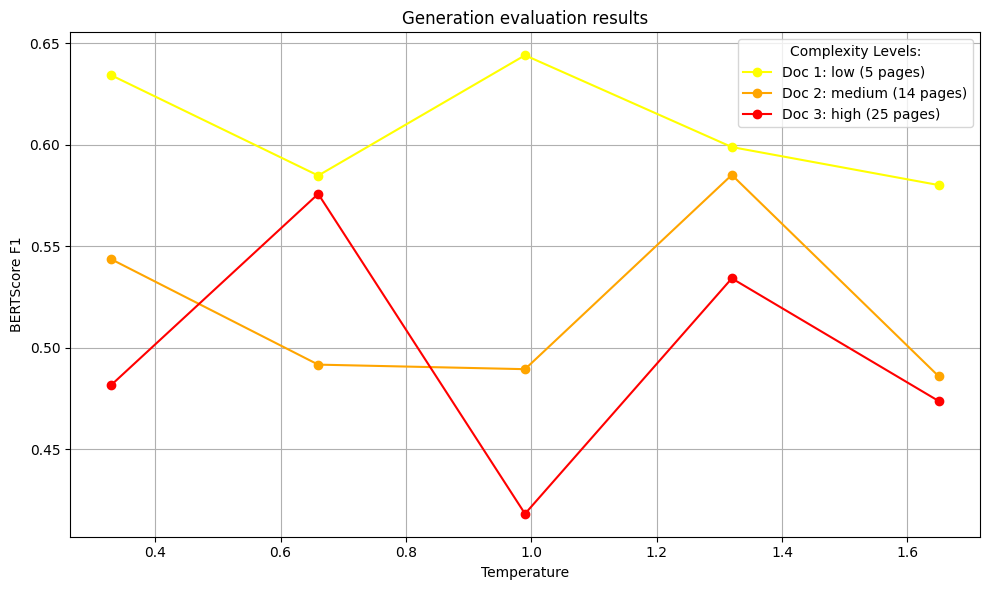

In [28]:
import matplotlib.pyplot as plt

# Extract data
temperatures1 = [d['temperature'] for d in doc1_results]
f1_scores1 = [d['bertscore_f1'] for d in doc1_results]

temperatures2 = [d['temperature'] for d in doc2_results]
f1_scores2 = [d['bertscore_f1'] for d in doc2_results]

temperatures3 = [d['temperature'] for d in doc3_results]
f1_scores3 = [d['bertscore_f1'] for d in doc3_results]

# Plot all on the same figure
plt.figure(figsize=(10, 6))
plt.plot(temperatures1, f1_scores1, marker='o', linestyle='-', color='yellow', label='Doc 1: low (5 pages)')
plt.plot(temperatures2, f1_scores2, marker='o', linestyle='-', color='orange', label='Doc 2: medium (14 pages)')
plt.plot(temperatures3, f1_scores3, marker='o', linestyle='-', color='red', label='Doc 3: high (25 pages)')

# Add labels, title, grid, and legend
plt.title('Generation evaluation results')
plt.xlabel('Temperature')
plt.ylabel('BERTScore F1')
plt.grid(True)
plt.legend(title='Complexity Levels:')
plt.tight_layout()
plt.show()
